# Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In this tutorial we use the defaul version of the CTGAN:
https://github.com/sdv-dev/CTGAN

We also need to install table evaluator to evaluate the quality of the generated synthetic data.

In [ ]:
%pip install ctgan


In [3]:
%pip install table_evaluator

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 31.8 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.0.3 which is incompatible.


Now we download a dataset that includes both continuous and discrete values. I chose a random dataset from Kaggle: https://www.kaggle.com/datasets/mirichoi0218/insurance

In [4]:
import pandas as pd
data = pd.read_csv('./ToN_IoT_2.csv')
selected_columns = ['src_port', 'dst_port', 'proto', 'service', 'duration', 'src_bytes', 'dst_bytes',
                    'conn_state', 'missed_bytes', 'src_pkts', 'src_ip_bytes', 'dst_pkts', 'dst_ip_bytes',
                    'weird_name', 'weird_addl', 'weird_notice','label', 'type']
selected_samples = pd.concat([
    data[data['type'] == 'password'].sample(n=500, random_state=42)[selected_columns],
    data[data['type'] == 'ransomware'].sample(n=500, random_state=42)[selected_columns],
    data[data['type'] == 'scanning'].sample(n=500, random_state=42)[selected_columns],
    data[data['type'] == 'xss'].sample(n=500, random_state=42)[selected_columns],
    data[data['type'] == 'mitm'].sample(n=500, random_state=42)[selected_columns]
])


In [5]:
selected_samples

,src_port,dst_port,proto,service,duration,src_bytes,dst_bytes,conn_state,missed_bytes,src_pkts,src_ip_bytes,dst_pkts,dst_ip_bytes,weird_name,weird_addl,weird_notice,label,type
29328,57616,80,tcp,http,0.020247,152,3558,SF,0,5,420,7,3930,-,-,-,1,password
4100,47740,21,tcp,ftp,10.280261,86,188,RSTR,0,17,978,16,1016,-,-,-,1,password
9267,50694,80,tcp,http,0.001904,170,3042,SF,0,6,490,7,3414,-,-,-,1,password
44253,46096,80,tcp,http,0.003194,153,463,SF,0,5,421,5,731,-,-,-,1,password
39719,45070,80,tcp,http,0.001655,167,2813,SF,0,5,435,6,3133,-,-,-,1,password
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23708,33210,443,tcp,ssl,0.409194,524,7124,SF,0,17,1392,12,7756,-,-,-,1,mitm
41327,34421,53,udp,dns,0.003523,84,436,SF,0,2,140,2,492,-,-,-,1,mitm
41611,53182,443,tcp,ssl,182.695665,1594,5306,SF,0,24,2574,21,6158,-,-,-,1,mitm
28310,43234,443,tcp,ssl,6.362619,350,2789,SF,0,10,878,7,3161,-,-,-,1,mitm


Next, we define a list with column names for categorical variables. This list will be passed to the model so that the model can decide how to process these fields.

In [6]:
categorical_features = ['src_port', 'dst_port', 'proto', 'service', 'duration', 'src_bytes', 'dst_bytes', 'conn_state', 'missed_bytes', 'src_pkts', 'src_ip_bytes', 'dst_pkts', 'dst_ip_bytes','weird_name', 'weird_addl', 'weird_notice','label', 'type']


#Model training

Next, we simply define an instance of CTGANSynthesizer and call the fit method with the dataframe and the list of categorical variables.

We train the model for 300 epochs only as the discriminator and generator loss becomes quite low after these many epochs.

In [7]:
from ctgan import CTGAN

ctgan = CTGAN(verbose=True)
ctgan.fit(selected_samples, categorical_features,epochs=100)

Gen. (1.74) | Discrim. (-0.12): 100%|██████████| 100/100 [1:17:41<00:00, 46.62s/it]


#Synthetic data generation

In [17]:
samples = pd.DataFrame()

# Số lượng mẫu cho mỗi loại tấn công
num_samples_per_attack = 1000

# Lặp qua từng loại tấn công và lấy mẫu ngẫu nhiên
for attack_type in ['password', 'ransomware', 'scanning', 'xss', 'mitm']:

    num_samples_available = len(data[data['type'] == attack_type])

    # Lấy mẫu ngẫu nhiên từ DataFrame gốc và thêm vào samples
    if num_samples_available < num_samples_per_attack:
            samples_for_attack = data[data['type'] == attack_type]
    else:
        samples_for_attack = data[data['type'] == attack_type].sample(n=num_samples_per_attack, replace=False, random_state=42)
    samples = pd.concat([samples, samples_for_attack])

In [18]:
samples['type'].value_counts()

type
password      1000
ransomware    1000
scanning      1000
xss           1000
mitm           721
Name: count, dtype: int64

In [19]:
import os

# Đường dẫn tới tệp CSV đích
output_file = 'ToN_IoT_1.csv'

# Kiểm tra xem tệp tồn tại không
if os.path.isfile(output_file):
    # Nếu tệp đã tồn tại, đọc dữ liệu từ tệp đích vào DataFrame
    existing_data = pd.read_csv(output_file)

    # Sắp xếp lại cột của DataFrame samples sao cho chúng giống với DataFrame existing_data
    samples = samples.reindex(columns=existing_data.columns)

    # Ghi dữ liệu mới vào tiếp theo mà không ghi đè
    samples.to_csv(output_file, mode='a', header=False, index=False)
else:
    # Nếu tệp không tồn tại, ghi dữ liệu mới vào tệp mới
    samples.to_csv(output_file, index=False)


In [21]:
data_new = pd.read_csv('./ToN_IoT_1.csv')
data_new

,src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,conn_state,...,http_response_body_len,http_status_code,http_user_agent,http_orig_mime_types,http_resp_mime_types,weird_name,weird_addl,weird_notice,label,type
0,192.168.1.30,45676,192.168.1.1,53,udp,dns,0.003166,54,54,SF,...,0,0,-,-,-,-,-,-,1,ddos
1,192.168.1.31,37914,192.168.1.190,80,tcp,http,0.339130,337,1919,SF,...,0,0,-,-,-,-,-,-,1,injection
2,192.168.1.152,1189,192.168.1.152,1189,tcp,-,0.247497,0,0,S0,...,0,0,-,-,-,-,-,-,0,normal
3,192.168.1.30,45006,192.168.1.184,443,tcp,-,0.000322,0,0,S1,...,0,0,-,-,-,-,-,-,1,ddos
4,192.168.1.30,60071,192.168.1.1,53,udp,dns,0.000009,74,90,SF,...,0,0,-,-,-,-,-,-,1,ddos
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95823,192.168.1.34,54528,52.37.53.14,443,tcp,ssl,6.391507,368,3157,SF,...,0,0,-,-,-,-,-,-,1,mitm
95824,192.168.1.31,50406,13.35.148.144,80,tcp,http,115.326300,880,1941,SF,...,0,0,-,-,-,-,-,-,1,mitm
95825,192.168.1.31,53116,192.168.1.1,53,udp,dns,0.044893,84,424,SF,...,0,0,-,-,-,-,-,-,1,mitm
95826,192.168.1.31,59482,104.16.163.13,443,tcp,ssl,0.179370,899,4569,SF,...,0,0,-,-,-,-,-,-,1,mitm


In [23]:
data_new['type'].value_counts()

type
normal        34955
backdoor      14102
dos           14094
ddos          13981
injection     13975
password       1000
ransomware     1000
scanning       1000
xss            1000
mitm            721
Name: count, dtype: int64



#Evaluation

In [ ]:
selected_data = data[selected_columns]
selected_data

,src_port,dst_port,proto,service,duration,src_bytes,dst_bytes,conn_state,missed_bytes,src_pkts,src_ip_bytes,dst_pkts,dst_ip_bytes,weird_name,weird_addl,weird_notice,label,type
0,45676,53,udp,dns,0.003166,54,54,SF,0,1,82,1,82,-,-,-,1,ddos
1,37914,80,tcp,http,0.339130,337,1919,SF,0,7,709,5,2187,-,-,-,1,injection
2,1189,1189,tcp,-,0.247497,0,0,S0,0,120,4800,0,0,-,-,-,0,normal
3,45006,443,tcp,-,0.000322,0,0,S1,0,2,112,1,60,-,-,-,1,ddos
4,60071,53,udp,dns,0.000009,74,90,SF,0,2,130,2,146,-,-,-,1,ddos
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91102,74,74,tcp,-,0.008967,0,0,REJ,0,4,160,4,160,-,-,-,1,dos
91103,137,137,udp,dns,1.503722,300,0,S0,0,6,468,0,0,-,-,-,0,normal
91104,39134,53,udp,dns,0.012897,41,89,SF,0,1,69,1,117,-,-,-,0,normal
91105,53648,53,udp,dns,0.000026,130,0,S0,0,2,186,0,0,-,-,-,0,normal


In [ ]:
samples

,src_port,dst_port,proto,service,duration,src_bytes,dst_bytes,conn_state,missed_bytes,src_pkts,src_ip_bytes,dst_pkts,dst_ip_bytes,weird_name,weird_addl,weird_notice,label,type
0,19911,80,tcp,http,0.000413,236,0,RSTO,0,2,104,1,696,NaN,NaN,NaN,1,dos
1,35116,51782,udp,dns,0.000140,0,112,OTH,94900,16,620,5,1664,NaN,NaN,NaN,0,normal
2,37010,40,udp,<NA>,60.876147,233,1124,SF,0,91,785,12,112,NaN,NaN,NaN,1,normal
3,49703,80,tcp,<NA>,160.420785,0,1486,S0,0,6,48,1,40,NaN,NaN,NaN,1,backdoor
4,42856,80,tcp,<NA>,0.000019,39,0,SF,0,120,48,0,3812,NaN,NaN,NaN,1,dos
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,83,80,tcp,<NA>,1.264965,43,0,SF,0,0,164,6,146,NaN,NaN,NaN,1,injection
996,51419,80,tcp,<NA>,0.000111,226,0,SF,0,2,40,1,40,NaN,NaN,NaN,1,backdoor
997,35902,79,tcp,http,0.000110,284,3440,REJ,0,7,4560,2,86,NaN,NaN,NaN,1,normal
998,37,80,tcp,http,0.000030,0,212,RSTO,0,5,474,3,3760,NaN,NaN,NaN,1,injection


<ipython-input-79-3734c054b72e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data.replace('-', pd.NA, inplace=True)


ValueError: min() arg is an empty sequence

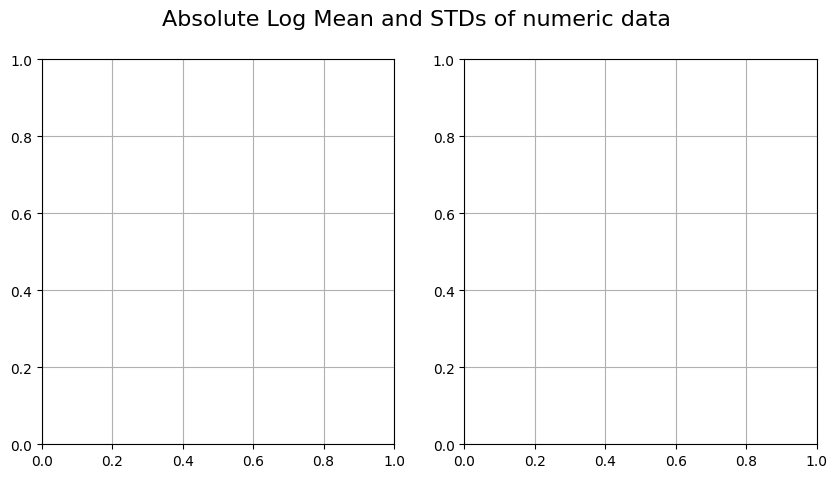

In [ ]:
from table_evaluator import TableEvaluator

# Tạo TableEvaluator với các cột đã chọn
table_evaluator = TableEvaluator(selected_data, samples, cat_cols=categorical_features)

# Thực hiện đánh giá và hiển thị kết quả
table_evaluator.visual_evaluation()
